In [70]:
import numpy as np
from astropy.io import fits
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

#from scipy import constants
#from scipy.interpolate import interp1d
#import time
#from os import path, getcwd
#from os import getcwd
#import inspect
#from math import pi
#import matplotlib.gridspec as gridspec

In [71]:
# read manga cube file

#ivar = np.transpose(cube['IVAR'].data, axes=(2, 1, 0))


cdir='./'
fname='manga-8329-6103-LOGCUBE.fits.gz'
fpath=cdir+fname
cube = fits.open(fpath)
flux=np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))
wave = cube['WAVE'].data
flux_header = cube['FLUX'].header

print('Xsize, Ysize: ',np.int(flux_header['NAXIS1']),np.int(flux_header['NAXIS2']))


Xsize, Ysize:  54 54


Text(0,0.5,'1E-17 erg/s/cm^2/Ang/spaxel')

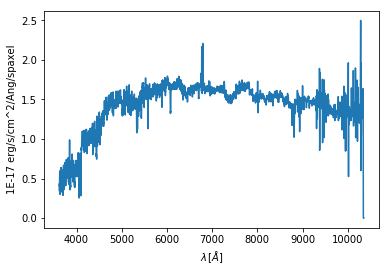

In [89]:
#plot manga spectrum at the center

x_center = np.int(flux_header['CRPIX1']) - 1
y_center = np.int(flux_header['CRPIX2']) - 1

x_plot=x_center
y_plot=y_center

#x_plot=28
#y_plot=35

plt.plot(wave, flux[x_plot, y_plot])
plt.xlabel('$\lambda \, [\AA]$')
plt.ylabel(flux_header['BUNIT'])

In [73]:
# process flux data 
do_not_use = (mask & 2**10) != 0
flux_m = np.ma.array(flux, mask=do_not_use)

#redshift = 0.0402719
redshift = 0.031267200
ind_wave = np.where((wave / (1 + redshift) > 6550) & (wave / (1 + redshift) < 6680))[0]
halpha = flux_m[:, :, ind_wave].sum(axis=2)
im = halpha.T

# Convert from array indices to arcsec relative to IFU center
dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
dy = flux_header['CD2_2'] * 3600.  # deg to arcsec
x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx * (-1)
y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

Text(0,0.5,'arcsec')

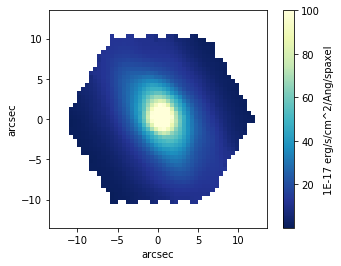

In [93]:
from matplotlib import cm
plt.imshow(im, extent=extent, cmap=cm.YlGnBu_r, vmin=0.1, vmax=100, origin='lower', interpolation='none')
plt.colorbar(label=flux_header['BUNIT'])
plt.xlabel('arcsec')
plt.ylabel('arcsec')

In [75]:
# read already measured velocity map
cdir='./'
fname='manga-8329-6103-LOGCUBE_MAPS-NONE-013.fits.gz'
fpath=cdir+fname
cube = fits.open(fpath)
velmap=cube['STELLAR_VEL'].data
nx, ny=np.int(flux_header['NAXIS1']) , np.int(flux_header['NAXIS2'])

idx=np.flatnonzero(velmap)
nidx=np.nonzero(velmap == 0)
velmap[nidx]=np.nan

medv, stdv, sigv=(np.median((velmap.flatten())[idx])), (np.std((velmap.flatten())[idx])), 2
velmap=velmap-medv

Text(0,0.5,'arcsec')

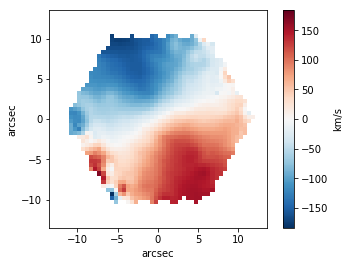

In [76]:
# plot velocity map
cmap= matplotlib.cm.RdBu_r
cmap.set_bad(color='white')
plt.imshow(velmap, extent=extent, cmap=cmap, vmin=(-stdv*sigv), vmax=stdv*sigv, origin='lower', interpolation='none')
plt.colorbar(label='km/s')
plt.xlabel('arcsec')
plt.ylabel('arcsec')

In [131]:
print(velmap.shape)
print(np.indices(velmap.shape))
a=(np.indices(velmap.shape))
print(a.shape)
aidx=np.arange(nx*ny)
print(aidx % nx)
print(aidx // nx)
ix=aidx % nx
iy=aidx // ny

incl=60/180*pi
incl=np.arccos(0.64180700)
print(incl)
phi0=28.838100/180*pi+pi/2

cent_x=0
cent_y=0

x_obs=(ix-(nx/2-0.5))*0.5
y_obs=(iy-(ny/2-0.5))*0.5
r_obs=((x_obs-cent_x)**2+(y_obs-cent_y)**2)**0.5

tanval=((y_obs-cent_y)/(x_obs-cent_x+r_obs))

phi_obs=2*np.arctan(tanval)
tan_theta=np.tan(phi_obs-phi0)/np.cos(incl)
cos_theta=1/((1+tan_theta**2)**0.5)
r_gal=r_obs*np.cos(phi_obs-phi0)/cos_theta

v_rot=velmap.flatten()/cos_theta/np.sin(incl)

major_idx=np.flatnonzero(np.abs( (phi_obs-phi0)/pi*180 % 180 ) < 30)
r_gal=r_gal[major_idx]
v_rot=v_rot[major_idx]

print(x_obs)
print(y_obs)
print(np.sin(incl))


(54, 54)
[[[ 0  0  0 ...  0  0  0]
  [ 1  1  1 ...  1  1  1]
  [ 2  2  2 ...  2  2  2]
  ...
  [51 51 51 ... 51 51 51]
  [52 52 52 ... 52 52 52]
  [53 53 53 ... 53 53 53]]

 [[ 0  1  2 ... 51 52 53]
  [ 0  1  2 ... 51 52 53]
  [ 0  1  2 ... 51 52 53]
  ...
  [ 0  1  2 ... 51 52 53]
  [ 0  1  2 ... 51 52 53]
  [ 0  1  2 ... 51 52 53]]]
(2, 54, 54)
[ 0  1  2 ... 51 52 53]
[ 0  0  0 ... 53 53 53]
0.8739440346236964
[-13.25 -12.75 -12.25 ...  12.25  12.75  13.25]
[-13.25 -13.25 -13.25 ...  13.25  13.25  13.25]
0.7668662039436867


(-300, 300)

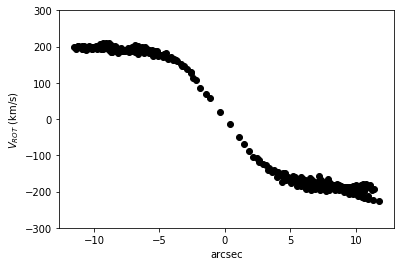

In [132]:
plt.plot(r_gal, v_rot, 'ko')
plt.xlabel('arcsec')
plt.ylabel('$V_{ROT}$ (km/s) ')
plt.ylim([-300,300])